In [1]:
import zipfile
from PIL import Image
import io
import matplotlib.pyplot as plt
import cv2
import numpy as np
import tensorflow as tf
import os
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Input, Concatenate, Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from sklearn.model_selection import train_test_split
import random

global_image_dim = 180

2024-04-30 19:12:47.127145: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-30 19:12:47.255140: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-30 19:12:48.268615: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# Load Datasets

In [2]:
high_path = './high-quality'
low_path = './low-quality'
categories = ['real', 'fake']

data_high = []
data_low = []

data_low_img = []
data_low_label = []

for category in categories:
    high_folder_path = os.path.join(high_path, category)
    low_folder_path = os.path.join(low_path, category)
    label = 1 if category == 'real' else 0

    for file in os.listdir(high_folder_path):
        if file.endswith(('jpg', 'png', 'jpeg')):  
            file_path = os.path.join(high_folder_path, file)
            image = Image.open(file_path)
            data_high.append((image, label))
            
    for file in os.listdir(low_folder_path):
        if file.endswith(('jpg', 'png', 'jpeg')):  
            file_path = os.path.join(low_folder_path, file)
            image = Image.open(file_path)
            data_low_img.append(image)
            data_low_label.append(label)
            data_low.append((image, label))

## Show data examples : High quality 

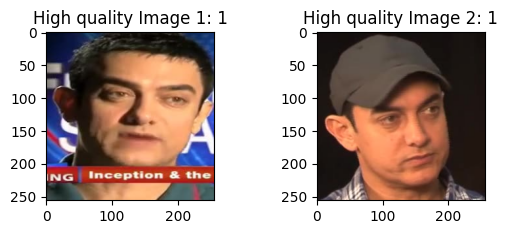

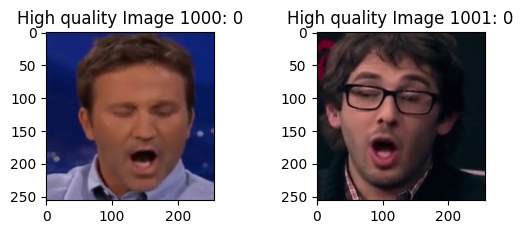

In [3]:

# Hight qulity 1 means real, 0 means fake

plt.subplot(2, 2, 1)  
plt.imshow(data_high[0][0], cmap='gray') 
plt.title(f'High quality Image 1: { data_high[0][1] }') 

plt.subplot(2, 2, 2) 
plt.imshow(data_high[1][0], cmap='gray')  
plt.title(f'High quality Image 2: { data_high[1][1] }') 
plt.show() 

plt.subplot(2, 2, 3)  
plt.imshow(data_high[1000][0], cmap='gray') 
plt.title(f'High quality Image 1000: { data_high[1000][1] }') 

plt.subplot(2, 2, 4) 
plt.imshow(data_high[1001][0], cmap='gray')  
plt.title(f'High quality Image 1001: { data_high[1001][1] }') 
plt.show() 

## Show data examples : Low quality 

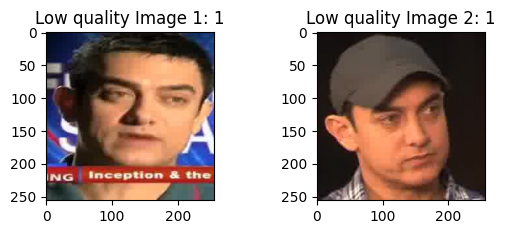

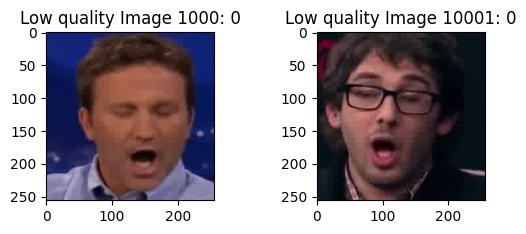

In [4]:
# Low qulity 1 means real, 0 means fake

plt.subplot(2, 2, 1)  
plt.imshow(data_low[0][0], cmap='gray') 
plt.title(f'Low quality Image 1: { data_low[0][1] }') 

plt.subplot(2, 2, 2) 
plt.imshow(data_low[1][0], cmap='gray')  
plt.title(f'Low quality Image 2: { data_low[1][1] }') 
plt.show() 

plt.subplot(2, 2, 3)  
plt.imshow(data_low[1000][0], cmap='gray') 
plt.title(f'Low quality Image 1000: { data_low[1000][1] }') 

plt.subplot(2, 2, 4) 
plt.imshow(data_low[1001][0], cmap='gray')  
plt.title(f'Low quality Image 10001: { data_low[1001][1] }') 
plt.show() 

# Preprocess with clahe

In [3]:
#The order of elements in the list is disrupted
random.shuffle(data_high)
random.shuffle(data_low)

In [4]:
def build_model_clahe_predictor(input_shape):
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        # predicte: clip_limit & tile_grid_size
        layers.Dense(2, activation='linear')
    ])
    
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

In [5]:
def preprocess_data(data):
    processed_images = []
    labels = []
    for image, label in data:
        # adjust size
        image = np.array(image.resize((global_image_dim, global_image_dim)))
        # Normalization
        image = image.astype(np.float32) / 255.0
        processed_images.append(image)
        labels.append(label)
    return np.array(processed_images), np.array(labels)

processed_high, labels_high = preprocess_data(data_high)
processed_low, labels_low = preprocess_data(data_low)

In [6]:
def apply_clahe(image, clip_limit,tile_grid_size):
    img_np = np.array(image)
    img_np = img_np[:, :, ::-1]  # Convert RGB to BGR
    img_lab = cv2.cvtColor(img_np, cv2.COLOR_BGR2Lab)  # Convert to Lab color space
    l, a, b = cv2.split(img_lab)  # Split into channels
    tile_grid_size_int = int(tile_grid_size)
    clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=(tile_grid_size_int, tile_grid_size_int))  # Apply CLAHE with specified parameters
    l_clahe = clahe.apply(l)  # Apply to L channel
    lab_clahe = cv2.merge((l_clahe, a, b))  # Merge back the channels
    img_clahe_bgr = cv2.cvtColor(lab_clahe, cv2.COLOR_Lab2BGR)  # Convert back to BGR
    img_clahe_rgb = img_clahe_bgr[:, :, ::-1]  # Convert BGR to RGB
    return Image.fromarray(img_clahe_rgb)

def apply_clahe_numpy(img_np,  clip_limit, tile_grid_size):
    img_np = img_np[:, :, ::-1]  # Convert RGB to BGR    
    img_lab = cv2.cvtColor(img_np, cv2.COLOR_BGR2Lab)  # Convert to Lab color space
    l, a, b = cv2.split(img_lab)  # Split into channels
    tile_grid_size_int = int(tile_grid_size)
    clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=(tile_grid_size_int, tile_grid_size_int))  # Apply CLAHE with specified parameters
    l_clahe = clahe.apply(l)  # Apply to L channel
    lab_clahe = cv2.merge((l_clahe, a, b))  # Merge back the channels
    img_clahe_bgr = cv2.cvtColor(lab_clahe, cv2.COLOR_Lab2BGR)  # Convert back to BGR
    img_clahe_rgb = img_clahe_bgr[:, :, ::-1]  # Convert BGR to RGB
    return img_clahe_rgb

def apply_merged_clahe(image, clip_limit, tile_grid_size):
    border = tile_grid_size // 2
    
    img_br = cv2.copyMakeBorder(np.array(image), border, 0, border, 0, cv2.BORDER_CONSTANT)
    img_br = apply_clahe_numpy(img_br, clip_limit, tile_grid_size)
    img_br = img_br[border:, border:]

    img_bl = cv2.copyMakeBorder(np.array(image), border, 0, 0, border, cv2.BORDER_CONSTANT)
    img_bl = apply_clahe_numpy(img_bl, clip_limit, tile_grid_size)
    img_bl = img_bl[border:, :-border]

    img_tr = cv2.copyMakeBorder(np.array(image), 0, border, border, 0, cv2.BORDER_CONSTANT)
    img_tr = apply_clahe_numpy(img_tr, clip_limit, tile_grid_size)
    img_tr = img_tr[:-border, border:]

    img_tl = cv2.copyMakeBorder(np.array(image), 0, border, 0, border, cv2.BORDER_CONSTANT)
    img_tl = apply_clahe_numpy(img_tl, clip_limit, tile_grid_size)
    img_tl = img_tl[:-border, :-border]
    
    img = np.array(image)
    img = apply_clahe_numpy(img, clip_limit, tile_grid_size)
    img_mixed = ((img_tl / 5) + (img_tr / 5) + (img_bl / 5) + (img_br / 5) + (img / 5)   ).astype(np.uint8)
    
    return Image.fromarray(img_mixed)

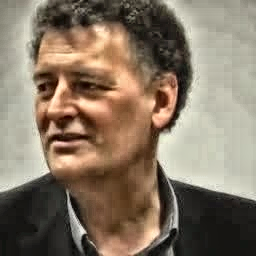

In [7]:
data_high[3][0]
apply_clahe(data_high[3][0], 5, 15)
apply_merged_clahe(data_high[3][0], 4, 15)

In [8]:
def enhance_images(data,clip_limit,tile_grid_size):
    enhanced_images = []
    enhanced_images_label = []
    for i in range(len(data)):
        enhanced_image = apply_clahe(data[i][0], clip_limit,tile_grid_size)
        enhanced_images.append(enhanced_image)
        enhanced_images_label.append(data[i][1])
    return enhanced_images,enhanced_images_label

# enhanced_images_high,enhanced_high_label = enhance_images(data_high,15,7)
# enhanced_images_low,enhanced_low_label = enhance_images(data_low,15,7)

# Get CLAHE parameters : clip_limit, tile_grid_size

/home/ivans/miniconda3/envs/tf/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2024-04-30 19:13:04.410116: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:02:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-30 19:13:04.720045: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:02:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-30 19:13:04.720413: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:02:00.0/n

Epoch 1/20


I0000 00:00:1714461186.655281   31504 service.cc:145] XLA service 0x7ff0b00057b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1714461186.655467   31504 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Ti, Compute Capability 8.6
2024-04-30 19:13:06.675928: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-04-30 19:13:06.798793: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907


10/44 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 63.0900 - mae: 6.1288

I0000 00:00:1714461190.416425   31504 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


44/44 ━━━━━━━━━━━━━━━━━━━━ 8s 84ms/step - loss: 31.8364 - mae: 3.8990 - val_loss: 4.3248 - val_mae: 1.5571
Epoch 2/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 3.9214 - mae: 1.5044 - val_loss: 3.3503 - val_mae: 1.4293
Epoch 3/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 3.3209 - mae: 1.4148 - val_loss: 3.5336 - val_mae: 1.4492
Epoch 4/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 3.2472 - mae: 1.3786 - val_loss: 3.1260 - val_mae: 1.3966
Epoch 5/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 2.9657 - mae: 1.3530 - val_loss: 3.4276 - val_mae: 1.4300
Epoch 6/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 3.1852 - mae: 1.3875 - val_loss: 3.9025 - val_mae: 1.5191
Epoch 7/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 3.3292 - mae: 1.4197 - val_loss: 3.2162 - val_mae: 1.4192
Epoch 8/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 2.8769 - mae: 1.3171 - val_loss: 3.2243 - val_mae: 1.4131
Epoch 9/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 2.6840 - mae: 1

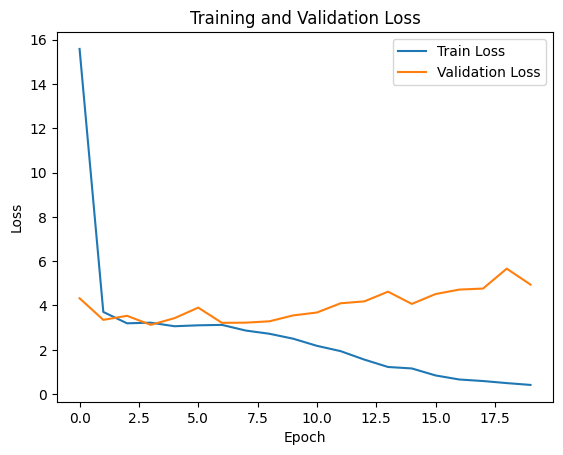

In [7]:
def generate_synthetic_clahe_params(num_samples):
     # Generating machine image brightness index, different illumination conditions
    brightness_levels = np.random.rand(num_samples)
     # Clip_limit according to the calculation of the original brightness, clip_limit according to the demand of the dark image
    clip_limits = 1 + 3 * (1 - brightness_levels) # clip_limit
     # Generating machine coherence index, model dissimilar coherence strength
    texture_levels = np.random.rand(num_samples)
     # Root construction calculation tile_grid_size, calculation construction calculation tile_grid_size, calculation tile_grid_size calculation tile_grid_size
    tile_grid_sizes = 8 + (8 * (1 - texture_levels)).astype(int) # tile_grid_size范围从8到16
    return np.vstack((clip_limits, tile_grid_sizes)).T


x_data = np.array(processed_low)  
num_images = len(processed_low)
y_data = generate_synthetic_clahe_params(num_images)
input_shape = x_data.shape[1:] 
model = build_model_clahe_predictor(input_shape)

# y_data is CLAHE parameters
history = model.fit(x_data, y_data, batch_size=32, epochs=20, validation_split=0.2)
 
loss, accuracy = model.evaluate(x_data, y_data)
y_pred_best_low = model.predict(x_data)
print(f"Test Loss: {loss}, Test Accuracy: {accuracy}")
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Apply CLAHE

In [8]:
def enhance_images_clahe(data, clip_limit, tile_size, enhance_function):
    enhanced_images = []
    enhanced_images_label = []
    for i in range(len(data)):
        enhanced_image = enhance_function(data[i][0],clip_limit, tile_size)
        enhanced_images.append(enhanced_image)
        enhanced_images_label.append(data[i][1])
    return enhanced_images,enhanced_images_label
    
def enhance_images(data,y_pred_best_low):
    enhanced_images = []
    enhanced_images_label = []
    for i in range(len(data)):
        enhanced_image = apply_clahe(data[i][0],y_pred_best_low[i][0],y_pred_best_low[i][1])
        enhanced_images.append(enhanced_image)
        enhanced_images_label.append(data[i][1])
    return enhanced_images,enhanced_images_label


enhanced_low_standard, enhanced_low_standard_label = enhance_images_clahe(data_low, 3, 15, apply_clahe)
enhanced_low_mixed, enhanced_low_mixed_label = enhance_images_clahe(data_low, 3, 15, apply_merged_clahe)
# enhanced_images_high,enhanced_high_label = enhance_images(data_high,15,7)


enhanced_images_low,enhanced_low_label = enhance_images(data_low,y_pred_best_low)

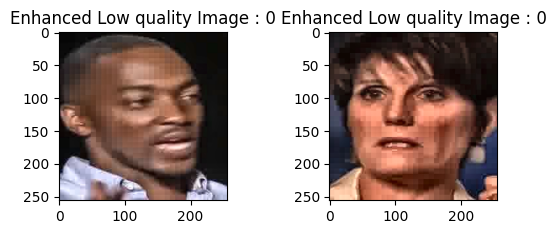

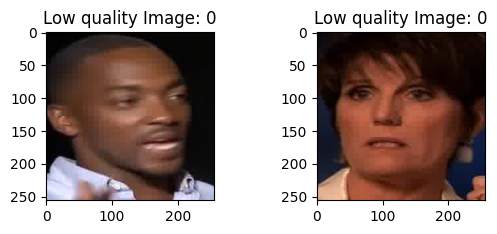

In [13]:
plt.subplot(2, 2, 1)  
plt.imshow(enhanced_images_low[2], cmap='gray') 
plt.title(f'Enhanced Low quality Image : { enhanced_low_label[0] }') 

plt.subplot(2, 2, 2) 
plt.imshow(enhanced_images_low[3], cmap='gray')  
plt.title(f'Enhanced Low quality Image : { enhanced_low_label[1] }') 
plt.show() 

plt.subplot(2, 2, 3)  
plt.imshow(data_low[2][0], cmap='gray') 
plt.title(f'Low quality Image: { data_low[0][1] }') 

plt.subplot(2, 2, 4) 
plt.imshow(data_low[3][0], cmap='gray')  
plt.title(f'Low quality Image: { data_low[1][1] }') 
plt.show() 


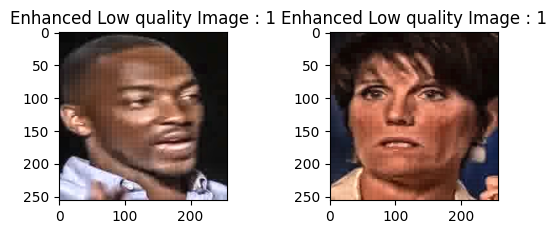

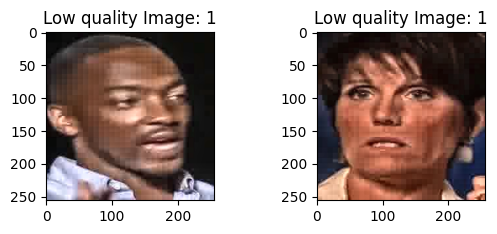

In [14]:
plt.subplot(2, 2, 1)  
plt.imshow(enhanced_low_mixed[2], cmap='gray') 
plt.title(f'Enhanced Low quality Image : { enhanced_low_label[2] }') 

plt.subplot(2, 2, 2) 
plt.imshow(enhanced_low_mixed[3], cmap='gray')  
plt.title(f'Enhanced Low quality Image : { enhanced_low_label[3] }') 
plt.show() 

plt.subplot(2, 2, 3)  
plt.imshow(enhanced_low_standard[2], cmap='gray') 
plt.title(f'Low quality Image: { data_low[2][1] }') 

plt.subplot(2, 2, 4) 
plt.imshow(enhanced_low_standard[3], cmap='gray')  
plt.title(f'Low quality Image: { data_low[3][1] }') 
plt.show() 

# Build Model

In [34]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout

def build_model(input_shape):

    base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape)

    base_model.trainable = False


    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    x = Dense(256, activation='relu')(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.2)(x)
    predictions = Dense(2, activation='softmax')(x)  

    model = Model(inputs=base_model.input, outputs=predictions)
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    return model

def get_model(num_classes = 2):
    # input_shape = (global_image_dim, global_image_dim, 3)  
    # model = build_model(input_shape)
    # return model
    
    data_augmentation = keras.Sequential(
      [
        layers.RandomFlip("horizontal",
                          input_shape=(global_image_dim,
                                      global_image_dim,
                                      3)),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.1),
      ]
    )

    model = Sequential([
          data_augmentation,
          # layers.Rescaling(1./255),
          layers.Conv2D(64, 3, padding='same', activation='relu'),
          layers.MaxPooling2D(),
          layers.Conv2D(128, 3, padding='same', activation='relu'),
          layers.MaxPooling2D(),
          layers.Conv2D(256, 3, padding='same', activation='relu'),
          layers.MaxPooling2D(),
          layers.Conv2D(256, 3, padding='same', activation='relu'),
          layers.MaxPooling2D(),
          layers.Dropout(0.2),
          layers.Flatten(),
          layers.Dense(256, activation='relu'),
          layers.Dense(num_classes, name="outputs")
        ])

    model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
    # input_shape = (global_image_dim, global_image_dim, 3)  
    # model = build_model(input_shape)
    return model

model = get_model()

# Train Model on low quality enhanced images

In [23]:
def preprocess_data_after(enhanced_images):
    processed_images = []
    for image in enhanced_images:
        image = np.array(image.resize((global_image_dim, global_image_dim)))
        # Normalization
        image = image.astype(np.float32) / 255.0
        processed_images.append(image)
    return np.array(processed_images)

In [24]:
X_low = preprocess_data_after(enhanced_images_low)
y_low = np.array(enhanced_low_label)
X_low_std = preprocess_data_after(enhanced_low_standard)
y_low_std = np.array(enhanced_low_standard_label)
X_low_mix = preprocess_data_after(enhanced_low_mixed)
y_low_mix = np.array(enhanced_low_mixed_label)
print(X_low_std.shape)
print(y_low_std.shape)

(1727, 180, 180, 3)
(1727,)


In [25]:
X_train_low, X_test_low, y_train_low, y_test_low = train_test_split(X_low, y_low, test_size=0.2) #enhanced
X_train_low_std, X_test_low_std, y_train_low_std, y_test_low_std = train_test_split(X_low_std, y_low_std, test_size=0.2) #enhanced
X_train_low_mix, X_test_low_mix, y_train_low_mix, y_test_low_mix = train_test_split(X_low_mix, y_low_mix, test_size=0.2) #enhanced
X_train_low_raw, X_test_low_raw, y_train_low_raw, y_test_low_raw = train_test_split(processed_low, labels_low, test_size=0.2) #raw

In [26]:
print(X_train_low_mix.shape)
print(X_train_low_raw.shape)

(1381, 180, 180, 3)
(1381, 180, 180, 3)


In [35]:
def train_and_evaluate_model_raw(X_train, y_train, X_test, y_test, batch_size=32, epochs=20):
    model = get_model()
    model.summary()
    history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_test, y_test))
    return model

def train_and_evaluate(X_train, y_train, X_test, y_test, batch_size=32, epochs=100):
    model = get_model()
    model.summary()
    train_and_evaluate_model(model, X_train, y_train, X_test, y_test, batch_size=batch_size, epochs=epochs)
    
def train_and_evaluate_model(model, X_train, y_train, X_test, y_test, batch_size=16, epochs=100):
    history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_test, y_test))
    loss, accuracy = model.evaluate(X_test, y_test)
    print(f"Test Loss: {loss}, Test Accuracy: {accuracy}")

    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()

    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.show()

model = build_model(input_shape=(global_image_dim,global_image_dim, 3))

/tmp/ipykernel_31352/1958908946.py:10: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape)


Epoch 1/50


2024-04-30 19:22:09.234108: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/sequential_14_1/dropout_11_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


44/44 ━━━━━━━━━━━━━━━━━━━━ 6s 79ms/step - accuracy: 0.5293 - loss: 0.7733 - val_accuracy: 0.5491 - val_loss: 0.6917
Epoch 2/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 75ms/step - accuracy: 0.5208 - loss: 0.6926 - val_accuracy: 0.4566 - val_loss: 0.6936
Epoch 3/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 74ms/step - accuracy: 0.5296 - loss: 0.6909 - val_accuracy: 0.4884 - val_loss: 0.6911
Epoch 4/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 74ms/step - accuracy: 0.5742 - loss: 0.6859 - val_accuracy: 0.7081 - val_loss: 0.6462
Epoch 5/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 74ms/step - accuracy: 0.6601 - loss: 0.6409 - val_accuracy: 0.7919 - val_loss: 0.4956
Epoch 6/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 73ms/step - accuracy: 0.7580 - loss: 0.5306 - val_accuracy: 0.7832 - val_loss: 0.4650
Epoch 7/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 73ms/step - accuracy: 0.7888 - loss: 0.4518 - val_accuracy: 0.7775 - val_loss: 0.4617
Epoch 8/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 73ms/step - accuracy: 0.8016 - loss: 0.4396 - val_accuracy: 0.8353 - val_loss: 0.

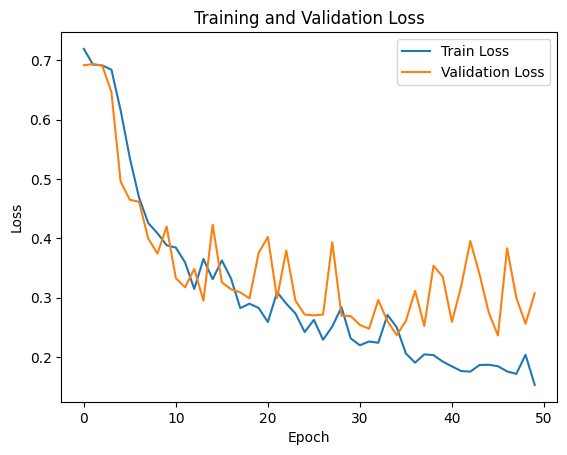

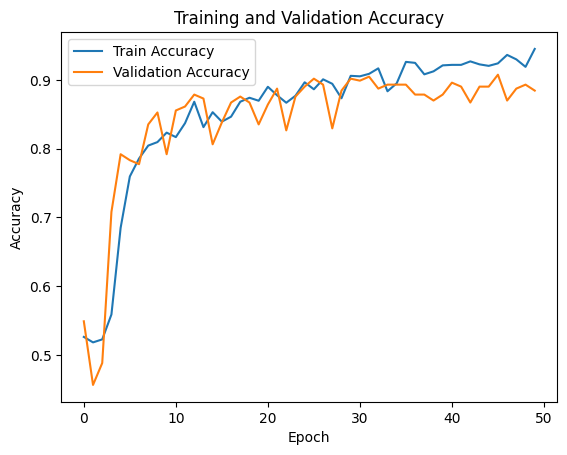

In [28]:
train_and_evaluate(X_train_low,y_train_low,X_test_low,  y_test_low, epochs = 50)

# Train Model on low quality raw images

Model: "sequential_24"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_23 (Sequential)      │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_47 (Conv2D)              │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_46 (MaxPooling2D) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_48 (Conv2D)              │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_47 (MaxPooling2D) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_49 (Conv2D)              │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_48 (MaxPooling2D) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_50 (Conv2D)              │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_49 (MaxPooling2D) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_12 (Flatten)            │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_41 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ outputs (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50


2024-04-30 19:31:03.767111: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/sequential_24_1/dropout_18_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


44/44 ━━━━━━━━━━━━━━━━━━━━ 6s 81ms/step - accuracy: 0.5069 - loss: 0.8428 - val_accuracy: 0.4884 - val_loss: 0.6928
Epoch 2/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 73ms/step - accuracy: 0.5201 - loss: 0.6907 - val_accuracy: 0.4942 - val_loss: 0.6891
Epoch 3/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 74ms/step - accuracy: 0.5013 - loss: 0.6946 - val_accuracy: 0.5116 - val_loss: 0.6861
Epoch 4/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 74ms/step - accuracy: 0.5209 - loss: 0.6939 - val_accuracy: 0.4884 - val_loss: 0.6910
Epoch 5/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 73ms/step - accuracy: 0.5144 - loss: 0.6882 - val_accuracy: 0.5665 - val_loss: 0.6835
Epoch 6/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 73ms/step - accuracy: 0.5432 - loss: 0.6831 - val_accuracy: 0.5173 - val_loss: 0.6967
Epoch 7/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 72ms/step - accuracy: 0.5894 - loss: 0.6746 - val_accuracy: 0.6127 - val_loss: 0.6459
Epoch 8/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 72ms/step - accuracy: 0.5733 - loss: 0.6815 - val_accuracy: 0.5145 - val_loss: 0.

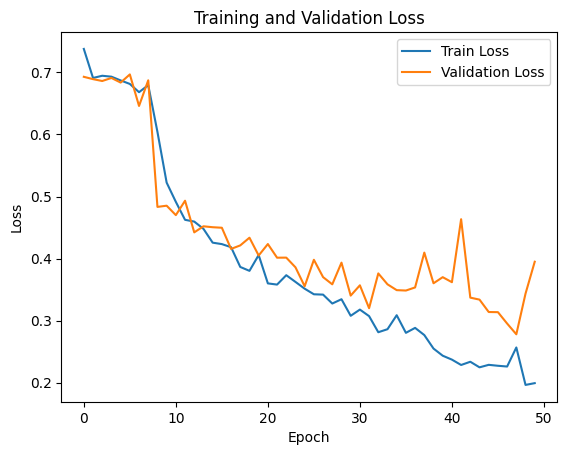

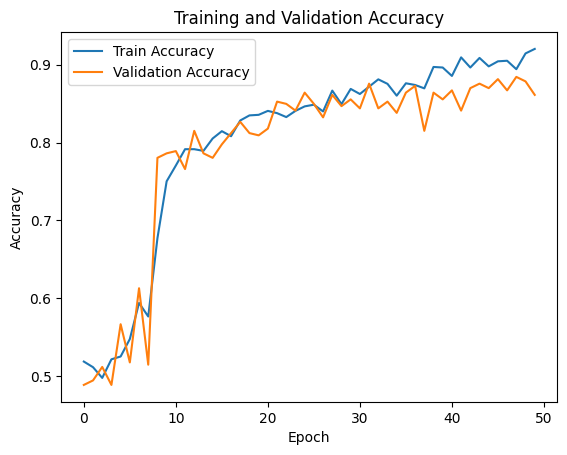

In [36]:
train_and_evaluate(X_train_low_raw, y_train_low_raw,X_test_low_raw, y_test_low_raw,epochs=50)

Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_15 (Sequential)      │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_31 (Conv2D)              │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_30 (MaxPooling2D) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_32 (Conv2D)              │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_31 (MaxPooling2D) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_33 (Conv2D)              │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_32 (MaxPooling2D) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_34 (Conv2D)              │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_33 (MaxPooling2D) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_8 (Flatten)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ outputs (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50


2024-04-30 19:25:53.929613: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/sequential_16_1/dropout_13_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


44/44 ━━━━━━━━━━━━━━━━━━━━ 5s 80ms/step - accuracy: 0.5140 - loss: 0.9176 - val_accuracy: 0.5145 - val_loss: 0.6916
Epoch 2/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 75ms/step - accuracy: 0.4899 - loss: 0.6933 - val_accuracy: 0.5376 - val_loss: 0.6892
Epoch 3/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 74ms/step - accuracy: 0.5691 - loss: 0.6900 - val_accuracy: 0.5665 - val_loss: 0.6884
Epoch 4/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 75ms/step - accuracy: 0.5253 - loss: 0.6916 - val_accuracy: 0.5578 - val_loss: 0.6916
Epoch 5/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 75ms/step - accuracy: 0.5412 - loss: 0.6859 - val_accuracy: 0.5751 - val_loss: 0.6869
Epoch 6/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 73ms/step - accuracy: 0.5764 - loss: 0.6839 - val_accuracy: 0.5376 - val_loss: 0.9680
Epoch 7/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 72ms/step - accuracy: 0.5898 - loss: 0.6989 - val_accuracy: 0.5607 - val_loss: 0.6564
Epoch 8/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 72ms/step - accuracy: 0.6037 - loss: 0.6473 - val_accuracy: 0.7948 - val_loss: 0.

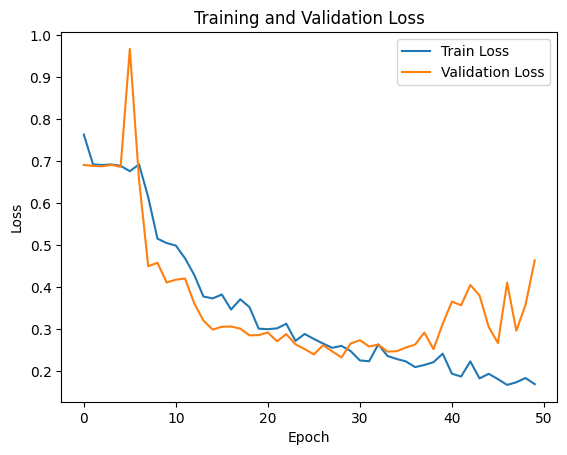

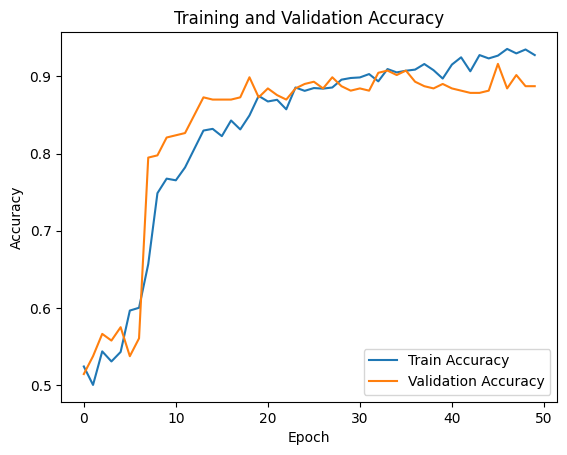

In [31]:
train_and_evaluate(X_train_low_std,y_train_low_std,X_test_low_std,  y_test_low_std, epochs=50)

Epoch 1/50


2024-04-30 18:14:23.365342: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/sequential_15_1/dropout_10_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


44/44 ━━━━━━━━━━━━━━━━━━━━ 5s 81ms/step - accuracy: 0.4855 - loss: 0.9139 - val_accuracy: 0.4509 - val_loss: 0.6966
Epoch 2/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 72ms/step - accuracy: 0.5433 - loss: 0.6854 - val_accuracy: 0.4624 - val_loss: 0.6914
Epoch 3/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 71ms/step - accuracy: 0.5573 - loss: 0.6860 - val_accuracy: 0.6358 - val_loss: 0.6825
Epoch 4/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 72ms/step - accuracy: 0.5656 - loss: 0.6769 - val_accuracy: 0.4509 - val_loss: 1.3350
Epoch 5/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 71ms/step - accuracy: 0.5599 - loss: 0.7460 - val_accuracy: 0.6012 - val_loss: 0.6761
Epoch 6/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 72ms/step - accuracy: 0.5078 - loss: 0.7011 - val_accuracy: 0.4566 - val_loss: 0.7155
Epoch 7/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 72ms/step - accuracy: 0.5499 - loss: 0.6800 - val_accuracy: 0.5578 - val_loss: 0.7028
Epoch 8/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 71ms/step - accuracy: 0.7163 - loss: 0.5736 - val_accuracy: 0.7659 - val_loss: 0.

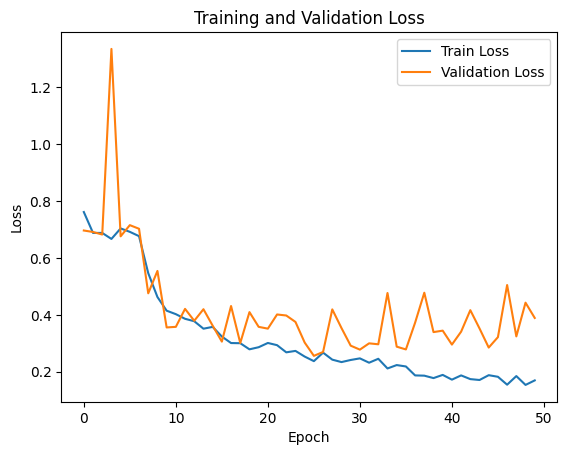

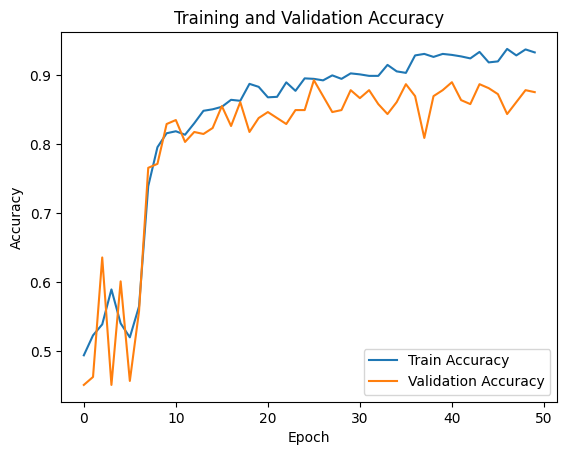

In [26]:
train_and_evaluate(X_train_low_mix,y_train_low_mix,X_test_low_mix,  y_test_low_mix, epochs=50)

# Train Model on high quality processed images

# Train Model on high quality raw images

In [27]:
random.shuffle(data_low)

In [49]:
def run_and_predict(data, clip_limit_low, clip_limit_high, window_size):
    split_ratio = 2
    data_len = len(data)
    chunk = data_len // split_ratio
    res = {}
    stored_train = {}
    for clip_limit in range(clip_limit_low, clip_limit_high + 1):
        res[clip_limit] = []
        stored_train[clip_limit] = None
        
    for i in range(split_ratio):
        for clip_limit in range(clip_limit_low, clip_limit_high + 1):
            stored_train[clip_limit] = None
        val = data[int(i * chunk):int((i+1) * chunk)]
        train = data[:int(i * chunk)] + data[int((i+1) * chunk):]
        print("VT", len(val), len(train), data_len, chunk)
        X_train = None
        y_train = None
        X_test = None
        y_test = None
        for clip_limit in range(clip_limit_low, clip_limit_high + 1):
            X_train_cl, y_train_cl = enhance_images_clahe(train, clip_limit, window_size, apply_clahe)
            X_test_cl, y_test_cl = enhance_images_clahe(val, clip_limit, window_size, apply_clahe)
            X_train_cl = preprocess_data_after(X_train_cl)
            X_test_cl = preprocess_data_after(X_test_cl)
            y_train_cl = np.array(y_train_cl)
            y_test_cl = np.array(y_test_cl)
            if(X_train is None):
                X_train = X_train_cl
            else:
                X_train = np.concatenate((X_train, X_train_cl))

            if(y_train is None):
                y_train = y_train_cl
            else:
                y_train = np.concatenate((y_train, y_train_cl))

            if(X_test is None):
                X_test = X_test_cl
            else:
                X_test = np.concatenate((X_test, X_test_cl))

            if(y_test is None):
                y_test = y_test_cl
            else:
                y_test = np.concatenate((y_test, y_test_cl))

            if(stored_train[clip_limit] is None):
                stored_train[clip_limit] = X_train_cl
            else:
                stored_train[clip_limit] = np.concatenate((stored_train[clip_limit], X_train_cl))

            # for x in X_train:
            #     stored_train[clip_limit].append(x) 
        print(len(X_train), len(y_train), len(X_test), len(y_test))
        model = train_and_evaluate_model_raw(X_train, y_train, X_test, y_test)
        for clip_limit in range(clip_limit_low, clip_limit_high + 1):
            tempRes = model.predict(stored_train[clip_limit])
            for x in tempRes:
                res[clip_limit].append(x)
    return res

clip_low = 3
clip_high = 6
clips = list(range(clip_low, clip_high + 1))

data_clipped = data_low[:1000]
outp = run_and_predict(data_clipped, clip_low,clip_high,15)
best_clips = []
for i in range(len(data_clipped)):
    best_clip = -1
    best_value = -100
    cur_label = data_clipped[i][1]
    for clip_limit in outp.keys():
        if outp[clip_limit][i][cur_label] > best_value:
            best_value = outp[clip_limit][i][cur_label]
            best_clip = clip_limit
    best_clips.append(best_clip-3)            

VT 500 500 1000 500
2000 2000 2000 2000


Model: "sequential_35"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_34 (Sequential)      │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_17 (Rescaling)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_68 (Conv2D)              │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_68 (MaxPooling2D) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_69 (Conv2D)              │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_69 (MaxPooling2D) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_70 (Conv2D)              │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_70 (MaxPooling2D) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_71 (Conv2D)              │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_71 (MaxPooling2D) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_30 (Dropout)            │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_17 (Flatten)            │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_43 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ outputs (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20


2024-04-30 19:01:23.514008: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/sequential_35_1/dropout_30_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


63/63 ━━━━━━━━━━━━━━━━━━━━ 9s 105ms/step - accuracy: 0.5209 - loss: 1.0180 - val_accuracy: 0.5020 - val_loss: 0.7041
Epoch 2/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 87ms/step - accuracy: 0.5225 - loss: 0.6908 - val_accuracy: 0.5225 - val_loss: 0.7014
Epoch 3/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 86ms/step - accuracy: 0.5508 - loss: 0.6840 - val_accuracy: 0.5420 - val_loss: 0.6997
Epoch 4/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 85ms/step - accuracy: 0.7075 - loss: 0.5697 - val_accuracy: 0.7545 - val_loss: 0.7004
Epoch 5/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 84ms/step - accuracy: 0.7804 - loss: 0.4645 - val_accuracy: 0.7990 - val_loss: 0.6138
Epoch 6/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 84ms/step - accuracy: 0.8128 - loss: 0.4215 - val_accuracy: 0.8060 - val_loss: 0.8012
Epoch 7/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 84ms/step - accuracy: 0.8423 - loss: 0.3618 - val_accuracy: 0.8070 - val_loss: 0.7991
Epoch 8/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 83ms/step - accuracy: 0.8562 - loss: 0.3381 - val_accuracy: 0.8225 - val_loss: 1

Model: "sequential_37"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_36 (Sequential)      │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_18 (Rescaling)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_72 (Conv2D)              │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_72 (MaxPooling2D) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_73 (Conv2D)              │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_73 (MaxPooling2D) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_74 (Conv2D)              │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_74 (MaxPooling2D) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_75 (Conv2D)              │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_75 (MaxPooling2D) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_31 (Dropout)            │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_18 (Flatten)            │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_44 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ outputs (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20


2024-04-30 19:03:29.485542: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/sequential_37_1/dropout_31_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


63/63 ━━━━━━━━━━━━━━━━━━━━ 8s 100ms/step - accuracy: 0.5040 - loss: 0.8780 - val_accuracy: 0.5080 - val_loss: 0.6924
Epoch 2/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 86ms/step - accuracy: 0.4996 - loss: 0.6933 - val_accuracy: 0.5080 - val_loss: 0.6919
Epoch 3/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 87ms/step - accuracy: 0.4960 - loss: 0.6936 - val_accuracy: 0.5080 - val_loss: 0.6927
Epoch 4/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 87ms/step - accuracy: 0.4949 - loss: 0.6939 - val_accuracy: 0.5225 - val_loss: 0.6905
Epoch 5/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 86ms/step - accuracy: 0.5537 - loss: 0.6892 - val_accuracy: 0.7045 - val_loss: 0.6395
Epoch 6/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 86ms/step - accuracy: 0.6699 - loss: 0.6305 - val_accuracy: 0.7830 - val_loss: 0.4860
Epoch 7/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 86ms/step - accuracy: 0.7839 - loss: 0.4873 - val_accuracy: 0.8265 - val_loss: 0.4155
Epoch 8/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 85ms/step - accuracy: 0.8330 - loss: 0.3951 - val_accuracy: 0.8500 - val_loss: 0

In [50]:
best_clips

[3,
 3,
 3,
 3,
 0,
 0,
 3,
 3,
 2,
 3,
 0,
 3,
 2,
 0,
 3,
 0,
 0,
 0,
 0,
 3,
 3,
 1,
 3,
 2,
 2,
 3,
 0,
 3,
 0,
 3,
 0,
 0,
 3,
 0,
 3,
 3,
 0,
 3,
 0,
 0,
 3,
 3,
 1,
 0,
 1,
 0,
 3,
 0,
 3,
 3,
 3,
 3,
 0,
 3,
 3,
 3,
 2,
 3,
 1,
 0,
 0,
 3,
 2,
 0,
 0,
 2,
 3,
 3,
 0,
 0,
 3,
 3,
 0,
 3,
 1,
 3,
 3,
 3,
 0,
 0,
 0,
 0,
 0,
 0,
 3,
 0,
 0,
 0,
 3,
 3,
 0,
 1,
 3,
 3,
 2,
 3,
 3,
 1,
 3,
 1,
 3,
 3,
 0,
 0,
 0,
 1,
 3,
 3,
 3,
 1,
 0,
 0,
 2,
 0,
 1,
 2,
 3,
 3,
 1,
 0,
 0,
 1,
 3,
 0,
 3,
 1,
 3,
 0,
 1,
 0,
 3,
 0,
 0,
 2,
 0,
 0,
 3,
 3,
 2,
 0,
 2,
 3,
 3,
 0,
 2,
 3,
 0,
 0,
 2,
 3,
 3,
 0,
 0,
 2,
 0,
 0,
 0,
 0,
 3,
 0,
 3,
 0,
 0,
 0,
 2,
 1,
 3,
 3,
 0,
 3,
 0,
 3,
 0,
 0,
 3,
 3,
 2,
 3,
 0,
 1,
 1,
 0,
 3,
 0,
 3,
 2,
 3,
 1,
 3,
 3,
 0,
 2,
 3,
 0,
 1,
 1,
 0,
 0,
 3,
 0,
 3,
 1,
 0,
 0,
 3,
 3,
 0,
 0,
 3,
 2,
 3,
 0,
 0,
 0,
 3,
 0,
 3,
 3,
 2,
 0,
 0,
 0,
 3,
 0,
 0,
 0,
 3,
 0,
 2,
 3,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 3,
 3,
 2,
 0,
 3,
 2,
 3,
 0,
 0,
 0,
 0,
 1,
 3,


In [51]:
z= 0
print(outp[3][z], outp[4][z], outp[5][z], outp[6][z], data_clipped[z][1])

[ 4.1653247 -3.4969268] [ 3.8866608 -3.1421156] [ 3.4824123 -2.6817808] [ 3.264047  -2.3196583] 1


/tmp/ipykernel_4973/3501407286.py:6: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape)


Epoch 1/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 10s 77ms/step - accuracy: 0.3408 - loss: 1.5712 - val_accuracy: 0.3050 - val_loss: 1.3523
Epoch 2/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.3845 - loss: 1.3227 - val_accuracy: 0.4150 - val_loss: 1.3226
Epoch 3/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.4106 - loss: 1.2623 - val_accuracy: 0.3650 - val_loss: 1.3342
Epoch 4/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.4158 - loss: 1.2321 - val_accuracy: 0.4150 - val_loss: 1.3348
Epoch 5/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.4491 - loss: 1.2187 - val_accuracy: 0.3650 - val_loss: 1.3349
Epoch 6/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.4935 - loss: 1.1322 - val_accuracy: 0.3850 - val_loss: 1.3244
Epoch 7/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.4824 - loss: 1.1545 - val_accuracy: 0.4050 - val_loss: 1.3340
Epoch 8/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.4809 - loss: 1.1826 - val_accuracy: 0.3850 - 

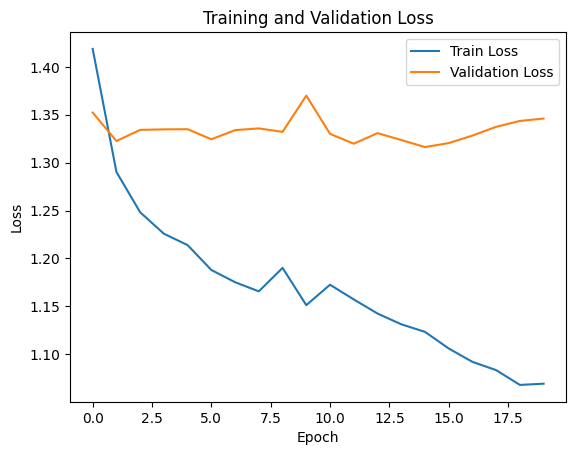

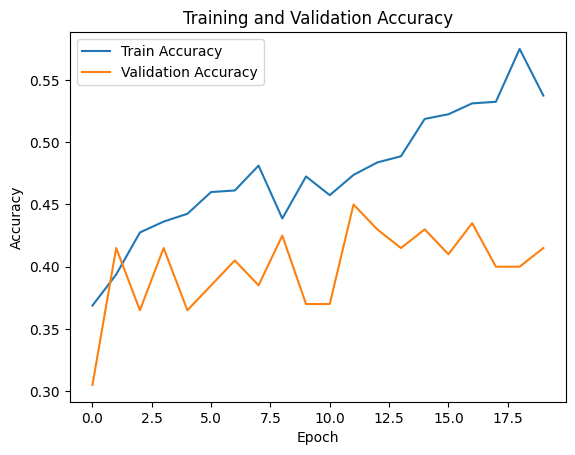

In [54]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
def build_model_clip(input_shape, clip_amount):

    base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape)

    base_model.trainable = False


    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(clip_amount, activation='softmax')(x)  

    model = Model(inputs=base_model.input, outputs=predictions)
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    return model

def get_model_clip(clip_amount):
    # model = Sequential([
    #   layers.Rescaling(1./255, input_shape=(224, 224, 3)),
    #   layers.Conv2D(16, 3, padding='same', activation='relu'),
    #   layers.MaxPooling2D(),
    #   layers.Conv2D(32, 3, padding='same', activation='relu'),
    #   layers.MaxPooling2D(),
    #   layers.Conv2D(64, 3, padding='same', activation='relu'),
    #   layers.MaxPooling2D(),
    #   layers.Flatten(),
    #   layers.Dense(128, activation='relu'),
    #   layers.Dense(clip_amount)
    # ])
    # model.compile(optimizer='adam',
    #           loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    #           metrics=['accuracy'])
    input_shape = (180, 180, 3)  
    model = build_model_clip(input_shape, clip_amount)
    return model

model_clip = get_model_clip(len(clips))
# X_clip_img_raw = [x[0] for x in data_clipped]
X_clip_img_raw, ___ = enhance_images_clahe(data_clipped, 0.01, 15, apply_clahe)
X_clip_img = preprocess_data_after(X_clip_img_raw)
y_clip = np.array(best_clips)
X_train_clip, X_test_clip, y_train_clip, y_test_clip = train_test_split(X_clip_img, y_clip, test_size=0.2) #enhanced
train_and_evaluate_model(get_model_clip(len(clips)),X_train_clip,y_train_clip, X_test_clip, y_test_clip, epochs = 20)
# history = model.fit(
#   X_train_clip, y_train_clip,
#   validation_data=(X_test_clip, y_test_clip),
#   epochs=10
# )


In [45]:
print(y_train_clip)

[2 3 0 3 2 3 0 1 0 3 3 0 2 3 0 0 1 0 0 1 3 1 3 2 3 0 1 2 2 0 0 0 0 0 1 1 2
 0 3 2 0 2 0 1 1 1 3 3 3 0 2 2 1 0 0 1 0 0 0 3 3 3 3 0 3 1 1 0 2 3 3 0 0 0
 3 3 1 3 3 2 2 1 3 1 0 0 2 2 3 2 3 0 0 0 3 1 3 1 2 0 1 0 1 0 3 1 0 0 1 1 1
 1 0 3 3 2 3 2 3 0 1 3 0 1 3 1 1 0 0 0 2 3 0 2 2 0 3 0 0 1 2 2 3 1 3 0 3 3
 3 2 0 2 0 3 3 2 3 0 1 3 3 2 3 0 1 3 1 2 3 1 0 1 2 3 2 3 3 1 0 0 2 1 0 2 0
 3 3 1 2 0 3 1 3 3 3 1 1 3 3 0 0 0 3 3 2 0 2 0 0 2 3 2 1 3 0 1 2 2 0 1 3 2
 1 3 3 0 1 0 3 3 1 0 0 3 1 2 3 0 3 3 2 2 0 1 3 3 0 0 2 0 3 3 3 0 3 1 3 3 0
 0 0 0 3 1 3 2 2 0 3 1 1 0 0 2 2 3 2 0 3 1 2 1 3 2 1 2 2 1 0 0 0 1 0 3 0 1
 0 3 1 2 0 1 3 1 0 0 2 0 1 2 1 3 3 3 3 3 1 2 1 0 1 1 2 0 3 2 1 0 0 2 0 3 0
 0 0 2 3 3 2 3 2 0 0 3 0 1 2 0 3 2 0 3 1 0 2 3 2 3 2 0 1 0 1 0 3 0 2 3 3 2
 3 3 1 1 2 1 0 3 0 1 0 3 1 2 0 1 0 0 1 0 0 3 0 0 0 3 2 2 2 3 0 0 1 3 0 2 1
 3 0 0 0 1 0 2 0 1 3 1 0 3 2 0 3 3 0 0 2 1 0 3 1 2 1 2 0 0 3 3 2 3 1 3 2 1
 0 1 2 0 0 0 0 2 1 3 0 0 1 2 0 0 2 1 0 1 3 2 0 3 0 0 0 2 3 0 1 0 0 2 0 3 3
 1 2 2 3 2 0 2 0 2 0 3 1 